In [1]:
#!/usr/bin/env python3
"""experiment_viterbi.ipynb
James Gardner 2020
ANU / Melbourne Uni

applies viterbi analysis pipeline to experiment video of
michelson interferometer with a mirror driven at a changing frequency
takes signal as time series of intensity at the video's centre
"""

import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook as tqdm

In [2]:
def fourier_spectrum(signal, fps, return_spectrum=False,
                     produce_plot=False, out_plot_name='tmp.pdf', out_plot_title=''):
    """finds fourier spectrum of signal time series as numpy array,
    has functionality to return and/or plot the sectrum (both default off),
    built from code originally found in tracker_time_series.ipynb
    """   
    signal_frames = len(signal)
    # will drop two frames later, fps: frames per second
    total_time = (signal_frames-2)/fps
    t = np.linspace(0,total_time,signal_frames)
    dt = t[1] - t[0]

    yf = np.fft.fft(signal)
    # normalised-absolute value of FT'd signal
    nrm_abs_yf = 2/signal_frames*np.abs(yf)
    # values at the centre of each frequency bin
    freq_scale = np.fft.fftfreq(len(yf),dt)
    # real signals are symmetric about 0 in frequency domain
    freq_scale_positive = freq_scale[:signal_frames//2]
    # frequency distribution values on positive side
    freq_prob = nrm_abs_yf[:signal_frames//2]
    
    if produce_plot:
        fig, (ax0,ax1) = plt.subplots(2,figsize=(14,14))
        ax0.plot(t,signal)
        ax0.set(title='signal: {}'.format(out_plot_title),ylabel='signal strength',xlabel='time, t')
        # signal average value gives magnitude of frequency = 0 term
        # simple fix is to drop first two bins, otherwise need to shift signal
        ax1.plot(freq_scale_positive[2:],freq_prob[2:])
        ax1.set(title='discrete FFT',ylabel='freq strength in signal',xlabel='frequency, f')
        plt.savefig(out_plot_name,bbox_inches='tight')
        plt.clf()
    
    if return_spectrum:
        return freq_prob[2:], freq_scale_positive[2:]        

In [3]:
def series_at_point(filename, point=None, return_series=False,
                    produce_plot=False, out_plot_name='tmp.pdf'):
    """finds time series green-channel intensity at a point in the video,
    has functionality to both return and plot series (both default off)
    """
    # standard python3-openCV point capture
    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    pbar = tqdm(total=total_frames-1)

    point_intensity = []
    # frame is numpy array of b,g,r values at each pixel
    ret, frame = cap.read()
    if point is None:
        # default to centre of frame
        point = tuple([int(i/2) for i in frame.shape[:2]])

    while ret:
        # green channel is the most important for greyscale intensity
        # https://en.wikipedia.org/wiki/Relative_luminance        
        # so approximate greyscale as just the green channel
        point_intensity.append(frame[point][1])

        ret, frame = cap.read()
        pbar.update(1)

    pbar.close()
    cap.release()

    if produce_plot:
        fourier_spectrum(point_intensity, fps, produce_plot=True,
                         out_plot_name=out_plot_name, out_plot_title=filename)
    if return_series:
        return point_intensity, fps

In [4]:
def viterbi_pathfinder(grid, scanning_range=3):
    """find the highest scoring path through the grid, left-to-right,
    as by the viterbi algorithm, with connections plus-minus the scanning_range;
    returns score grid for best path to each node and a bitmap of the total best path
    """
    # normalised grid, algorithm goal is to maximise product of values
    ngrid  = grid/np.max(grid)
    # logarithm avoids underflow, equvivalent to maximise sum of log of values
    lngrid = np.log(ngrid)
    
    long_timesteps = grid.shape[1]

    # keep track of running scores for best path to each node
    score_grid  = np.copy(lngrid)
    pathfinder_flag = len(lngrid[:,0])
    # pathfinder stores the survivor paths, i.e. the previous best step
    # to allow back-tracking to recover the best total path at the end
    pathfinder = np.full(np.shape(lngrid), pathfinder_flag)
    # pathfinder flag+1 for reaching the first, 0-index column        
    pathfinder[:,0] = pathfinder_flag+1       

    # implementation of the viterbi algorithm itself
    # finding the best path to each node, through time
    # see: https://www.youtube.com/watch?v=6JVqutwtzmo
    for j in range(1,long_timesteps):
        for i in range(len(score_grid[:,j])):
            # index values for where to look relative to i in previous column
            k_a = max(0, i-scanning_range) 
            k_b = min(len(score_grid[:,j-1])-1,
                      i+scanning_range)
            window = score_grid[:,j-1][k_a:k_b+1]
            # find the best thing nearby in the previous column ...
            window_score = np.max(window)
            window_ref   = k_a+np.argmax(window)
            # ... and take note of it, summing the log of values
            score_grid[i][j] += window_score
            pathfinder[i][j] = window_ref 

    # look at the very last column, and find the best total ending ...
    best_score  = np.max(score_grid[:,-1])
    best_end = np.argmax(score_grid[:,-1])
    # ... and retrace its steps through the grid
    best_path_back = np.full(long_timesteps,pathfinder_flag+2)
    best_path_back[-1] = best_end
    # best_path_back is the viterbi path, the highest scoring overall 
    # path_grid is the binary image of the viterbi path taken
    path_grid = np.zeros(np.shape(ngrid))
    tmp_path = pathfinder[best_end][-1]

    for j in reversed(range(0,long_timesteps-1)):
        path_grid[tmp_path][j] = 1
        # take pathfinder value in current step and follow it backwards
        best_path_back[j] = tmp_path    
        tmp_path = pathfinder[tmp_path][j]

    # make sure we got all the way home
    # (that the retrace found the initial edge)
    assert tmp_path == pathfinder_flag+1
    
    return score_grid, path_grid

In [5]:
def inj_wandering_signal(duration=300, fps=16000,
                         meander_amp=9, meander_decay=0.01, meander_freq=0.005,                     
                         filetag='webcam', return_freq_series=False, save_to_csv=False,
                         save_wav_recording=False, plot_wandering_signal = False):
    """creates wandering frequency, FM-modulated signal to test viteri analysis,
    default arguments are for testing the webcam, else see below for photodiode arguments:
    meander_amp, meander_decay, meander_freq = 300, 0.01, 0.01
    filetag = 'podo'  
    """
    # 5 minutes duration
    long_timesteps = fps*duration

    bin_time = np.linspace(0,300,long_timesteps)
    # meander is the long scale change in the sine frequency
    meander = lambda x: meander_amp*(
        np.exp(-x*meander_decay)*np.sin(meander_freq*2*np.pi*x))

    initial_frequency = 5
    # initial_frequency = 440
    wandering_freqs = initial_frequency + meander(bin_time)

    big_n = bin_time.shape[0]
    freq_series = np.zeros((100, 2))
    freq_series[:, 0], freq_series[:, 1] = (bin_time[::big_n//99],
                                      wandering_freqs[::big_n//99])
    
    if save_to_csv:
        # careful, inj_wandering_webcam is the frequency, not the actual signal
        np.savetxt('inj_wandering_{}.csv'.format(filetag), freq_series, delimiter=',')

    # sin(2*pi*f*t)
    # therefore sin(g(t)), 2*pi*f = dg/dt
    # sin(2*pi*\int{f(t)dt}) gives f = f(t)
    # and cumsum is discrete \int (integral)
    # https://au.mathworks.com/matlabcentral/answers/217746-
    # implementing-a-sine-wave-with-linearly-changing-frequency

    inj_signal = np.sin(2*np.pi*np.cumsum(wandering_freqs)/fps)
    if save_wav_recording:
        # this is the signal to play (i.e. inject) into the interferometer
        wavfile.write('inj_{}.wav'.format(filetag), int(fps), inj_signal)

    if plot_wandering_signal:
        plt.figure(figsize=(14, 7))
        plt.plot(bin_time, wandering_freqs)
        # plt.xlim(0, 60)
        plt.title('{} viterbi test: injected frequency versus time'.format(filetag))
        plt.xlabel('time, t / s')
        plt.ylabel('injected signal frequency, f / Hz')
        plt.savefig('wandering_{}.pdf'.format(filetag))
        plt.clf()
        
    if return_freq_series:
        return freq_series

In [6]:
class PointViterbi(object):
    """finds viterbi path through frequency spectrum measured at
    centre point over time for changing driving frequency
    """      
    def __init__(self,filename,long_timesteps=None,scanning_range=3):
        # start by finding the signal to be split into bins
        long_signal, fps = series_at_point(filename,return_series=True)

        total_frames = len(long_signal)
        duration = total_frames/fps
        if long_timesteps is None:
            # for every minute, add an extra 20 long time bins
            long_timesteps = int(20*duration/60)
        # q,r = divmod(a,b) s.t. a = q*b+r
        bin_frames, bin_remainder = divmod(total_frames,long_timesteps)
        # bin_duration = bin_frames/fps
        # acts as flag to stop short of the remainder, which is lost
        bin_last = total_frames - bin_remainder
        # always has long_timesteps number of chunks
        bin_signals = [long_signal[i: i+bin_frames] for i in range(0, bin_last, bin_frames)]

        # creating the signal grid
        # positive side of the fourier spectrum will have half bin_frames
        # minus 2 from cutting out the average value, frequency = 0, signal
        grid_frames = bin_frames//2-2
        grid = np.zeros((grid_frames,long_timesteps))

        for i,signal in enumerate(bin_signals):
            # columns are each spectrum, rows are frequency through time
            col, freq_scale_cut = fourier_spectrum(signal, fps, return_spectrum=True)
            grid[:,i] = col
            
        path_grid = viterbi_pathfinder(grid, scanning_range)[1]
        
        ngrid = grid/np.max(grid)
        self.ngrid = ngrid
        self.path_grid = path_grid
        # _plot_bundle not meant to be accessed other than for plotting
        self._plot_bundle = filename, long_timesteps, duration, grid_frames, freq_scale_cut 

    def plot(self, filetag=None, x_tick_skip=10, y_tick_skip=8):
        """saves plots of the signal grid and the recovered viterbi path,
        filetag is added to standardised plot filenames
        """
        # mirror _plot_bundle assignment above
        filename, long_timesteps, duration, grid_frames, freq_scale_cut = self._plot_bundle
        
        if filetag is None:
            c0, c1 = filename.find('expt_'), filename.find('.mp4')
            filetag = filename[c0+len('expt_'):c1]         

            x_tick_vals = np.arange(0, duration, 30)
            x_ticks_0 = x_tick_vals*long_timesteps/duration
            x_tick_labels_0 = x_tick_vals.astype('int')

            y_tick_vals = np.arange(1, 15, 2)
            y_ticks_0 = (y_tick_vals-freq_scale_cut[0])*len(freq_scale_cut)/(
                freq_scale_cut[-1]-freq_scale_cut[0])
            y_tick_labels_0 = ['{:.1f}'.format(i) for i in y_tick_vals]

            pg = (self.path_grid)
            pgp = np.argwhere(pg == 1)
            pgp[:,[0,1]] = pgp[:,[1,0]]
            pgp = pgp[pgp[:,0].argsort()]
            inj_signal = inj_wandering_signal(return_freq_series=True)[:,1][1:]

            plt.plot(figsize=(14,7))
            plt.imshow(self.ngrid, cmap='viridis')
            plt.plot(pgp[:,1], 'x', color='azure', ms=2)
            plt.plot(np.searchsorted(freq_scale_cut, inj_signal), '.', color='fuchsia', ms=2) 
            plt.xticks(x_ticks_0, x_tick_labels_0)
            plt.yticks(y_ticks_0, y_tick_labels_0)
            plt.ylabel('frequency, f / Hz')
            plt.xlabel('time, t / s')
            plt.gca().invert_yaxis()
                        
            plt.savefig('expt_overlay_2_{}.pdf'.format(filetag), bbox_inches='tight')
            plt.clf()        

In [7]:
# old methods to test the video and produce plots
filename = 'expt_4_0209.mp4'

cap = cv2.VideoCapture(filename)
ret, frame = cap.read()
cv2.imwrite('tmp_webcam_still.png',frame)
cap.release()

# plt.imshow(frame)
plt.plot(230, 240, marker='o', markersize=5, color="red")
plt.imshow(plt.imread('tmp_webcam_still.png'))
plt.axis('off')
plt.savefig('webcam_still_0_{}.pdf'.format(filename), bbox_inches = 'tight')
plt.clf()
os.remove('tmp_webcam_still.png')

signal, fps = series_at_point(filename, point=(230,240), return_series=True)
freq_prob, freq_scale = fourier_spectrum(signal, fps, return_spectrum=True)

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(freq_scale, freq_prob)
ax.set(xlabel='frequency, f / Hz', ylabel='Fourier amplitude')
ax.xaxis.set_ticks(np.arange(0, 16, 2))
ax.xaxis.set_ticklabels(['{:.1f}'.format(i) for i in np.arange(0, 16, 2)])
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.label.set_size(20)
plt.savefig('webcam_spectrum_{}.pdf'.format(filename), bbox_inches = 'tight')
plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

In [127]:
# finding FWHM of the webcam spectrum
i0 = np.searchsorted(freq_scale,2.05)
i1 = np.searchsorted(freq_scale,2.15)
xx = freq_scale[i0:i1]
yy = freq_prob[i0:i1]

from scipy import interpolate
f = interpolate.interp1d(xx, yy)
xnew = np.linspace(x.min(), x.max(), 100)
ynew = f(xnew)

f1 = interpolate.interp1d(yy[1:3], xx[1:3])
f2 = interpolate.interp1d(yy[3:5], xx[3:5])
x1, x2 = f1(hm), f2(hm)
fw = x2 - x1
print("FW", fw, "at HM", hm)

FW 0.032787477266316145 at HM 8.815440846957626


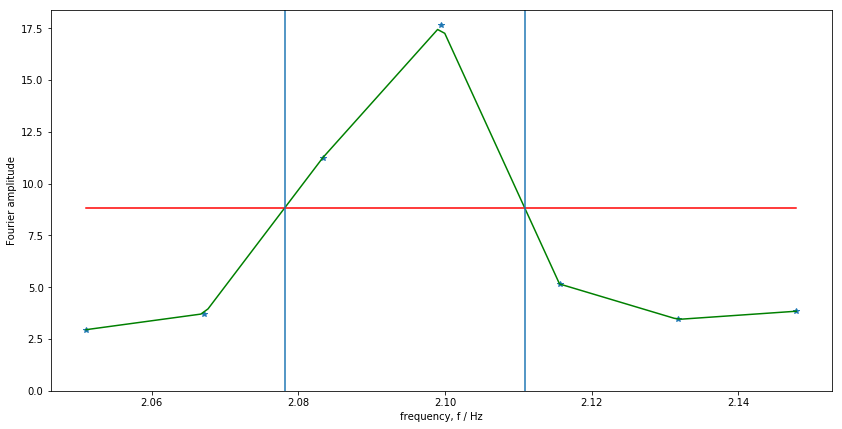

In [141]:
fig, ax = plt.subplots(figsize=(14,7))
# ax.plot(xx, yy, 'k,')
ax.plot(x, y, '*', xnew, ynew, 'g-')
ax.set(xlabel='frequency, f / Hz', ylabel='Fourier amplitude')
ax.set_ylim([0,None])

hm = yy[3]/2
ax.plot(xx, np.full(xx.shape, hm), 'r')

ax.axvline(x=x1)
ax.axvline(x=x2)

plt.show()

In [8]:
# as in main.py
PointViterbi('expt_viterbi_test_webcam.mp4', scanning_range=1).plot()

<Figure size 432x288 with 0 Axes>